# Load dataset

In [1]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch


In [21]:
from torchvision.datasets import CocoDetection, VisionDataset, wrap_dataset_for_transforms_v2
import json
import os
from typing import List, Any, Tuple
from PIL import Image
from torchvision.utils import draw_bounding_boxes
from torchvision.tv_tensors import Image as IMG, BoundingBoxes, BoundingBoxFormat, Mask
import torch
from torchvision.ops import box_convert

transform = EfficientNet_B0_Weights.DEFAULT.transforms()
class MyCocoDetection(VisionDataset):
    def __init__(self, root, annFile, transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        with open(annFile, 'r', encoding='utf-8') as f:
            self.coco = json.load(f)
        self.ids = sorted(self.coco['images'], key=lambda x: x['id'])

    def __len__(self):
        return len(self.ids)

    def _load_image(self, id: int) -> Image.Image:
        path = ""
        for ele in self.ids:
            if id == ele['id']:
                path = ele['file_name']
                break
        return IMG(Image.open(os.path.join(self.root, path)).convert("RGB"))

    def _load_target(self, id: int) -> List[Any]:
        res = []
        for ele in self.coco['annotations']:
            if id == ele['image_id']:
                res.append(ele)
        return res

    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        if not isinstance(index, int):
            raise ValueError(
                f"Index must be of type integer, got {type(index)} instead.")

        id = index
        image = self._load_image(id)
        target = self._load_target(id)

        if self.transforms is not None:
            image, target = self.transforms(image, target)
        boxes = []
        labels = []
        for ele in target:
            boxes.append(ele['bbox']),
            labels.append(ele['category_id']),
        target_dict = {
            'boxes': box_convert(
                BoundingBoxes(boxes, format=BoundingBoxFormat.XYWH, canvas_size=image.shape[1:3]), 
                'xywh', 'xyxy'
            ),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }
        
        return image, target_dict

dataset = MyCocoDetection(root=r"C:\Users\Vitus\Downloads\hello.v3i.coco\val",
                          annFile=r"C:\Users\Vitus\Downloads\hello.v3i.coco\labels\val_1.json", transform=transform)

In [22]:
from torchvision.models.detection.retinanet import RetinaNet

In [25]:
print(dataset[0][1])
# print(dataset.coco['categories'])

img = IMG(dataset[0][0])
# bbox = BoundingBoxes(dataset[0][1][0]['bboxes'], format=BoundingBoxFormat.XYWH, canvas_size=img.shape[1:3])
# bbox = box_convert(bbox, 'xywh', 'xyxy')
bbox = dataset[0][1]['boxes']
# print(bbox)

draw = draw_bounding_boxes(image=img, boxes=bbox, labels=["1"], width=5, colors='green', fill=True)

{'boxes': tensor([[279, 179, 511, 282]]), 'labels': tensor([3])}


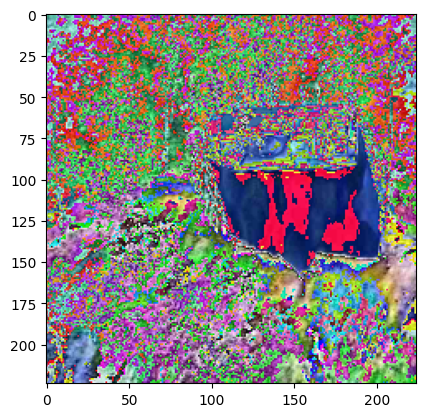

In [26]:
import matplotlib.pyplot as plt
plt.imshow(draw.permute(1,2,0))
plt.show()

# Luyện với torchvision

In [41]:
# ...existing code...
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import seed_everything

seed_everything(42, verbose=False)
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(
    dataset=dataset, lengths=[train_size, val_size])

# Custom collate function
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

train_dataloader = DataLoader(train_dataset, 16, True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 16, False, num_workers=0, collate_fn=collate_fn)
# ...existing code...

In [42]:
model = fasterrcnn_mobilenet_v3_large_320_fpn(weights=None, weights_backbone=None, num_classes=len(dataset.coco['categories']))
# model.to('cuda')
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
backbone = efficientnet_b0(weights=None).features
backbone.out_channels = 1280

In [43]:
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                 output_size=7,
                                                 sampling_ratio=2)

model = FasterRCNN(backbone,
    num_classes=len(dataset.coco['categories']),
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    min_size=224,
    max_size=480
)

In [48]:
from pytorch_lightning import LightningModule, Trainer
from torchvision.ops import box_iou
class ObjectDetector(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        images, targets = batch
        # self.model.train()
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        self.log('train_loss', losses, prog_bar=True)
        return losses

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        # self.model.train()
        # loss_dict = self.model(images, targets)
        # losses = sum(loss for loss in loss_dict.values())
        # self.log('val_loss', losses, prog_bar=True)
        # Inference (cần eval mode)
        # self.model.eval()
        # with torch.no_grad():
        y_hat = self.model(images)
        
        # Tính IoU nếu có predictions và targets
        if len(y_hat) > 0 and len(y_hat[0]['boxes']) > 0 and len(targets[0]['boxes']) > 0:
            iou = box_iou(y_hat[0]['boxes'], targets[0]['boxes'])
            if iou.numel() > 0:
                self.log('val_iou', iou.max(dim=1)[0].mean(), prog_bar=True, on_step=False, on_epoch=True)
        
        # return losses

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.005,
                                    momentum=0.9, weight_decay=0.0005)
        return optimizer
trainer = Trainer(max_epochs=10, max_time="00:04:04:00")
object_detector = ObjectDetector(model)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [49]:
trainer.fit(object_detector, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 84.2 M | train
---------------------------------------------
84.2 M    Trainable params
0         Non-trainable params
84.2 M    Total params
336.711   Total estimated model params size (MB)
351       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 36/36 [11:47<00:00,  0.05it/s, v_num=14, train_loss=0.0741, val_iou=4.79e-5]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 36/36 [11:50<00:00,  0.05it/s, v_num=14, train_loss=0.0741, val_iou=4.79e-5]
